# Mask Detection Demo - Serving (2 / 2)
The following example demonstrates a serving workflow - deploying the model to a Nuclio function allowing users to send an http request with an image url and receive a 
response back with the probability that the person in the image is wearing a mask or not.

#### Key Technologies:
- [**PyTorch**](https://pytorch.org/) to train the model
- [**Nuclio**](https://nuclio.io/) to create a high-performance serverless Serving function
- [**MLRun**](https://www.mlrun.org/) to orchestrate the process

#### Credits:

* The model is trained on a dataset containing images of people with or without masks. The data used was taken from Prajna Bhandary, [github link](https://github.com/prajnasb/observations). 
* The training code is taken from Adrian Rosebrock, COVID-19: Face Mask Detector with OpenCV, Keras/TensorFlow, and Deep Learning, PyImageSearch, [page link](https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/), accessed on 29 June 2021

#### Table of Contents:
1. [Setup the Project and Environment](#section_1)
2. [Write the Serving Code](#section_2)
3. [Create the Serving Function](#section_3)
4. [Deploy the Model](#section_4)

## 1. Set up the Project and Environment

Get our project and set the environment.

In [1]:
import mlrun
import os

# Create the project:
project_name='mask-detection-2'
project_dir = os.path.abspath('./')
project = mlrun.new_project(project_name, project_dir)

# Set the environment:
mlrun.set_environment(project=project.metadata.name)

> 2021-08-29 19:26:24,378 [warning] Failed resolving version info. Ignoring and using defaults
> 2021-08-29 19:26:26,486 [warning] Unable to parse server or client version. Assuming compatible: {'server_version': '0.7.0-rc10', 'client_version': 'unstable'}
> 2021-08-29 19:26:26,525 [info] loaded project mask-detection-2 from MLRun DB


('mask-detection-2', 'v3io:///projects/{{run.project}}/artifacts')

## 2. Write the Serving Code

Here we will write the code our serving function will use. We wish our data to go through the following structure:
1. `resize` - Read the URL into an array and resize it to 224x224.
2. `preprocess` - Use MobileNetV2 preprocessing function.
3. `mlrun.frameworks.keras.KerasModelServer` - Infer the inputs through the model and return the predictions.

Step 3 is using MLRun's `V2ModelServer` for tf.keras. It is implemented in the code and can be imported from:

```python
from mlrun.frameworks.keras import KerasModelServer
```

This class can be inherited and its preprocess, post-process, predict and explain method can be overridden. In this example, we are using the default `KerasModelServer` to show the topology feature of our serving functions.

In [2]:
# mlrun: start-code

In [3]:
from typing import Any, List, Dict

import os
from PIL import Image
import urllib.request
import torch
import torchvision

import mlrun
from mlrun.frameworks.pytorch import PyTorchModelServer

In [4]:
def read_url(event: Dict) -> List[Image.Image]:
    inputs = event["data_url"]
    images = []
    
    for image_url in inputs:
        urllib.request.urlretrieve(image_url, "temp.png")
        image = Image.open("temp.png")
        images.append(image)
    
    return images

In [5]:
def preprocess(images: List[Image.Image]) -> List[torch.Tensor]:
    transforms_composition = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
    
    preprocessed_images = []
    
    for image in images:
        preprocessed_image = transforms_composition(image)
        preprocessed_images.append(preprocessed_image)
    
    return {"inputs": preprocessed_images}

In [6]:
# mlrun: end-code

## 3. Create the Serving Function

The serving function kind is using [Nuclio](https://github.com/nuclio/nuclio/): a high-performance serverless event 
and data processing open-source platform.
With just a few lines of code we can take our model, **expose** it with an **http endpoint** and deploy it on 
**high-performance** infrastructure that can easily scale up to serve on a **production environment** with hundreds of 
thousands of requests per second.

In [7]:
serving_function = mlrun.code_to_function(
    "mask-detecting", 
    kind="serving", 
    image="guyliguazio/ml-models-gpu-066:tf243",
    with_doc=False
)

Now, in order to insert our functions flow, we will use `set_topology` and add our steps and model to the graph:

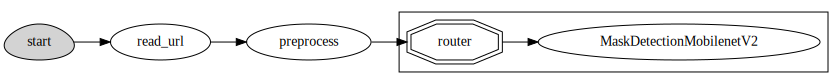

In [8]:
graph = serving_function.set_topology("flow", engine="async")

graph.to(handler="read_url", name="read_url").\
      to(handler="preprocess", name="preprocess")
router = graph.add_step("*", name="router", after="preprocess", full_event=True).respond()
router.add_route("MaskDetectionMobilenetV2", class_name="mlrun.frameworks.pytorch.PyTorchModelServer", model_path='store://models/mask-detection-2/job-trainer-local-run_MaskDetectionMobilenetV2')

graph.plot(rankdir='LR')

## 4. Deploy the Model

We will test our model on images using their urls. We will use a `test` method to draw the url image and send it to our deployed serving function:

In [9]:
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

options = ["with mask", "without mask"]
image_urls = [
    'https://s3.envato.com/files/321053037/323%202020_June_PORTO_446-Edit.jpg',  # With mask
    'https://media.glamour.com/photos/5a425fd3b6bcee68da9f86f8/master/pass/best-face-oil.png'  # Without mask
]

def test_image_classification(image_url: str, is_local: bool = False):
    # Draw Image:
    response = requests.get(image_url)
    plt.imshow(Image.open(BytesIO(response.content)))
    
    # Predict:
    if is_local:
        server = serving_function.to_mock_server()
        response = server.test(path='/v2/models/MaskDetectionMobilenetV2/predict', body={"data_url": [image_url]})
        server.wait_for_completion()
    else:
        response = serving_function.invoke(path='v2/models/MaskDetectionMobilenetV2/predict', body={"data_url": [image_url]})
    
    # Print the prediction:
    prediction = response['outputs'][0]
    print("Classified: {}\n".format(options[np.argmax(prediction)]))
    print("with mask probability:\t\t{}\n"
          "without mask probability:\t{}".format(prediction[0], prediction[1]))

### 4.1. Deploy locally:

In order to test our function, we will create a mock server (simulator) and test the graph with our images:

> 2021-08-29 19:26:37,122 [info] downloading v3io:///projects/mask-detection-2/artifacts/MaskDetectionMobilenetV2_custom_objects_map.json to local tmp
> 2021-08-29 19:26:37,130 [info] downloading v3io:///projects/mask-detection-2/artifacts/MaskDetectionMobilenetV2_custom_objects.zip to local tmp
> 2021-08-29 19:26:37,310 [info] model MaskDetectionMobilenetV2 was loaded
> 2021-08-29 19:26:37,310 [info] Initializing endpoint records
> 2021-08-29 19:26:37,338 [info] Loaded ['MaskDetectionMobilenetV2']
Classified: with mask

with mask probability:		0.5279486775398254
without mask probability:	0.47205135226249695


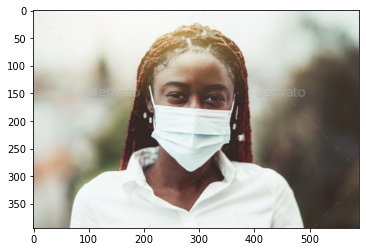

In [10]:
test_image_classification(image_url=image_urls[0], is_local=True)

> 2021-08-29 19:26:38,381 [info] downloading v3io:///projects/mask-detection-2/artifacts/MaskDetectionMobilenetV2_custom_objects_map.json to local tmp
> 2021-08-29 19:26:38,390 [info] downloading v3io:///projects/mask-detection-2/artifacts/MaskDetectionMobilenetV2_custom_objects.zip to local tmp
> 2021-08-29 19:26:38,547 [info] model MaskDetectionMobilenetV2 was loaded
> 2021-08-29 19:26:38,548 [info] Initializing endpoint records
> 2021-08-29 19:26:38,574 [info] Loaded ['MaskDetectionMobilenetV2']
Classified: without mask

with mask probability:		0.31038811802864075
without mask probability:	0.6896118521690369


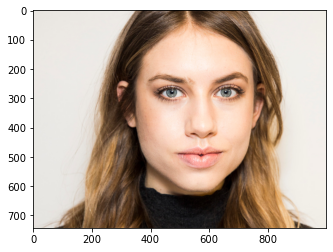

In [11]:
test_image_classification(image_url=image_urls[1], is_local=True)

### 4.2. Deploy a Real-time Serverless Function:

In [18]:
serving_function.apply(mlrun.platforms.auto_mount())
serving_function.deploy()

> 2021-08-03 09:08:05,248 [info] Starting remote function deploy
2021-08-03 09:08:05  (info) Deploying function
2021-08-03 09:08:05  (info) Building
2021-08-03 09:08:05  (info) Staging files and preparing base images
2021-08-03 09:08:05  (info) Building processor image
2021-08-03 09:08:06  (info) Build complete
2021-08-03 09:08:14  (info) Function deploy complete
> 2021-08-03 09:08:15,139 [info] function deployed, address=default-tenant.app.nlwdgzfqdequ.iguazio-cd2.com:32569


'http://default-tenant.app.nlwdgzfqdequ.iguazio-cd2.com:32569'

Classified: with mask

with mask probability:		0.9863876104354858
without mask probability:	0.01361243985593319


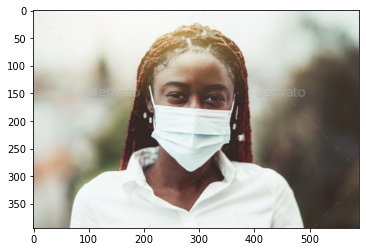

In [19]:
test_image_classification(image_url=image_urls[0])

Classified: without mask

with mask probability:		0.051049139350652695
without mask probability:	0.9489508867263794


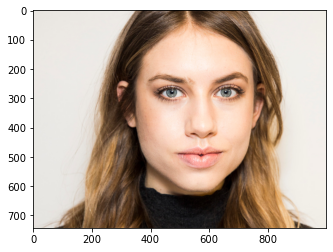

In [20]:
test_image_classification(image_url=image_urls[1])